In [1]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import RegressionResults
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
sns.set(style="ticks")
%matplotlib inline

/Users/krader/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
nyc_cab_df = pd.read_csv('nyc_car_hire_data.csv', low_memory=False)


In [11]:
print(nyc_cab_df.shape)
nyc_cab_df.head()

(1873671, 30)


,AWND,Base,Day,Dropoff_latitude,Dropoff_longitude,Ehail_fee,Extra,Fare_amount,Lpep_dropoff_datetime,MTA_tax,...,TMIN,Tip_amount,Tolls_amount,Total_amount,Trip_distance,Trip_type,Type,VendorID,lpep_pickup_datetime,Trip Length (min)
0,4.7,B02512,1,NaN,NaN,NaN,NaN,33.863498,2014-04-01 00:24:00,NaN,...,39,NaN,NaN,NaN,4.083561,NaN,1,NaN,2014-04-01 00:11:00,13.0
1,4.7,B02512,1,NaN,NaN,NaN,NaN,19.022892,2014-04-01 00:29:00,NaN,...,39,NaN,NaN,NaN,3.605694,NaN,1,NaN,2014-04-01 00:17:00,12.0
2,4.7,B02512,1,NaN,NaN,NaN,NaN,25.498981,2014-04-01 00:34:00,NaN,...,39,NaN,NaN,NaN,4.221763,NaN,1,NaN,2014-04-01 00:21:00,13.0
3,4.7,B02512,1,NaN,NaN,NaN,NaN,28.024628,2014-04-01 00:39:00,NaN,...,39,NaN,NaN,NaN,2.955510,NaN,1,NaN,2014-04-01 00:28:00,11.0
4,4.7,B02512,1,NaN,NaN,NaN,NaN,12.083589,2014-04-01 00:40:00,NaN,...,39,NaN,NaN,NaN,1.922292,NaN,1,NaN,2014-04-01 00:33:00,7.0


In [3]:
def train_test_split(df, n_samples, validation=False):
    if validation:
        nyc_cab_sample = df.sample(n=n_samples)

        nyc_cab_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
        nyc_cab_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)

        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        non_test = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]
        
        msk = np.random.rand(len(non_test)) < 0.7
        train = non_test[msk]
        validation = non_test[~msk]
        
        return train, validation, test
    
    else:
        nyc_cab_sample = df.sample(n=n_samples)

        nyc_cab_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
        nyc_cab_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)

        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        train = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]

        return train, test

---

## Dimensionality Reduction: PCA

In [4]:
train, validation, test = train_test_split(nyc_cab_df, 1000, validation=True)

y_train = train['Fare_amount'].values
y_val = validation['Fare_amount'].values
y_test = test['Fare_amount'].values

regression_model = LinearRegression(fit_intercept=True)

all_predictors = ['Trip Length (min)', 'Type', 'Trip_distance', 'TMAX', 'TMIN', 
                  'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude', 
                  'Pickup_latitude', 'SNOW', 'SNWD', 'PRCP']

train.describe()

,AWND,Day,Dropoff_latitude,Dropoff_longitude,Ehail_fee,Extra,Fare_amount,Lpep_dropoff_datetime,MTA_tax,PRCP,...,TMIN,Tip_amount,Tolls_amount,Total_amount,Trip_distance,Trip_type,Type,VendorID,lpep_pickup_datetime,Trip Length (min)
count,533.000000,533.000000,381.000000,381.000000,0.0,381.000000,533.000000,533.000000,381.000000,533.000000,...,533.000000,381.000000,381.000000,381.000000,533.000000,360.000000,533.000000,381.000000,533.000000,533.000000
mean,6.272983,15.260788,40.647671,-73.737406,NaN,0.393701,14.927224,13.962477,0.486877,0.261332,...,43.530957,1.028740,0.118320,14.544698,3.007122,1.025000,0.285178,1.784777,13.699812,11.818011
std,1.770641,8.697804,2.088787,3.787967,NaN,0.376776,8.881933,6.688455,0.080039,0.864190,...,6.127520,1.860855,0.774411,9.926822,2.512425,0.156342,0.451923,0.411517,6.679557,8.243857
min,2.000000,1.000000,0.000000,-74.016167,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,31.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,4.900000,8.000000,40.714752,-73.968994,NaN,0.000000,8.000000,10.000000,0.500000,0.000000,...,40.000000,0.000000,0.000000,8.000000,1.520000,1.000000,0.000000,2.000000,9.000000,7.000000
50%,5.800000,15.000000,40.754448,-73.943794,NaN,0.500000,13.000000,16.000000,0.500000,0.000000,...,43.000000,0.000000,0.000000,11.900000,2.406727,1.000000,0.000000,2.000000,15.000000,10.000000
75%,8.300000,23.000000,40.801552,-73.901405,NaN,0.500000,20.275281,19.000000,0.500000,0.070000,...,46.000000,1.500000,0.000000,17.100000,3.630000,1.000000,1.000000,2.000000,19.000000,14.000000
max,9.400000,30.000000,40.932575,0.000000,NaN,1.000000,58.500000,23.000000,0.500000,4.970000,...,59.000000,11.620000,5.330000,69.330000,20.880000,2.000000,1.000000,2.000000,23.000000,54.000000


### 1. Variable Selection: Backwards

In [12]:
def get_aic(X_train, y_train):
    X_train = add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    return model.aic

X_train = train[all_predictors].values
predictors = [(all_predictors, get_aic(X_train, y_train))]

for k in range(len(all_predictors), 1, -1):
    best_k_predictors = predictors[-1][0]
    aics = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = train[k_minus_1].values

        aics.append(get_aic(X_train, y_train))
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(aics)]]))
    predictors.append((best_k_minus_1, np.min(aics)))
    
best_predictor_set = sorted(predictors, key=lambda t: t[1])[-1]

In [13]:
best_predictor_set = sorted(predictors, key=lambda t: t[1])[0]

X_train = train[best_predictor_set[0]].values
X_val = validation[best_predictor_set[0]].values  
X_test = test[best_predictor_set[0]].values  
regression_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print('best predictor set: {}\ntest R^2: {}'.format(best_predictor_set[0], regression_model.score(X_test, y_test)))

best predictor set: ['Type', 'Pickup_latitude', 'Trip_distance', 'SNWD', 'SNOW', 'Trip Length (min)']
test R^2: 0.8696564260764411


## 2. Variable Selection: LASSO Regression

In [14]:
X_train = train[all_predictors].values
X_val = validation[all_predictors].values
X_non_test = np.vstack((X_train, X_val))
X_test = test[all_predictors].values

y_non_test = np.hstack((y_train, y_val))

lasso_regression = Lasso(alpha=1.0, fit_intercept=True)
lasso_regression.fit(X_non_test, y_non_test)

print('Lasso regression model:\n {} + {}^T . x'.format(lasso_regression.intercept_, lasso_regression.coef_))



Lasso regression model:
 0.8989838454858443 + [ 0.29912786  4.55900377  1.92934513 -0.         -0.          0.00758634
  0.         -0.04644646  0.          0.          0.          0.        ]^T . x


In [15]:
print('Test R^2: {}'.format(lasso_regression.score(X_test, y_test)))

Test R^2: 0.8253541202656242


### 3. Principal Component Regression

In [24]:
pca_all = PCA()
pca_all.fit(X_non_test)

print('First 4 principal components:\n', pca_all.components_[0:4])
print('Explained variance ratio:\n', pca_all.explained_variance_ratio_)

First 4 principal components:
 [[  2.39129056e-02  -1.52589992e-03   2.87820181e-03   8.15273795e-01
    5.30856898e-01  -1.66247307e-01  -1.57138583e-01   1.63510006e-02
   -9.18124937e-03  -0.00000000e+00   0.00000000e+00  -1.59625033e-02]
 [ -4.81556857e-02  -1.64875776e-03   8.71237863e-03  -1.95383366e-01
   -1.16363766e-01  -6.82620696e-01  -6.92730264e-01  -2.87939549e-03
    2.04933364e-03  -0.00000000e+00  -0.00000000e+00   5.33823735e-03]
 [  9.62900731e-01  -5.74858553e-03   2.52808711e-01  -2.66439844e-02
   -2.31060283e-02  -4.15207358e-02  -1.18366711e-02   6.63443885e-02
   -3.68951248e-02  -0.00000000e+00  -0.00000000e+00  -2.48879974e-03]
 [ -4.24750484e-03  -1.28064076e-03  -8.79072218e-03   5.43141125e-01
   -8.38916835e-01   2.59209473e-04  -1.26252332e-02   1.35518981e-02
   -7.80620455e-03  -0.00000000e+00  -0.00000000e+00  -2.67441606e-02]]
Explained variance ratio: [  3.52498964e-01   3.12127677e-01   2.40830333e-01   4.55437699e-02
   3.29216180e-02   7.4382478

In [18]:
pca = PCA(n_components=4)
pca.fit(X_non_test)
X_non_test_pca = pca.transform(X_non_test)
X_test_pca = pca.transform(X_test)

print('Explained variance ratio:', pca.explained_variance_ratio_)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)
Explained variance ratio: [ 0.35249896  0.31212768  0.24083033  0.04554377]


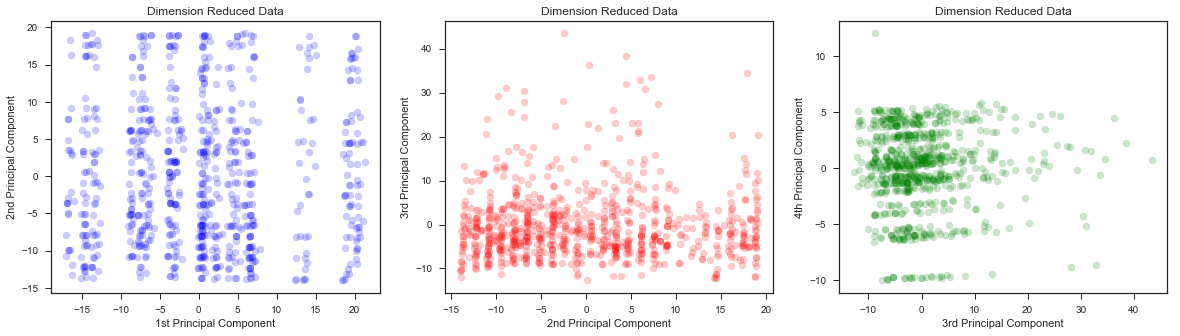

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].scatter(X_non_test_pca[:, 0], X_non_test_pca[:, 1], color='blue', alpha=0.2, label='train R^2')

ax[0].set_title('Dimension Reduced Data')
ax[0].set_xlabel('1st Principal Component')
ax[0].set_ylabel('2nd Principal Component')

ax[1].scatter(X_non_test_pca[:, 1], X_non_test_pca[:, 2], color='red', alpha=0.2, label='train R^2')

ax[1].set_title('Dimension Reduced Data')
ax[1].set_xlabel('2nd Principal Component')
ax[1].set_ylabel('3rd Principal Component')

ax[2].scatter(X_non_test_pca[:, 2], X_non_test_pca[:, 3], color='green', alpha=0.2, label='train R^2')

ax[2].set_title('Dimension Reduced Data')
ax[2].set_xlabel('3rd Principal Component')
ax[2].set_ylabel('4th Principal Component')

plt.show()

In [11]:
print('first pca component:\n', pca.components_[0])
print('\nsecond pca component:\n', pca.components_[1])
print('\nthird pca component:\n', pca.components_[2])
print('\nfourth pca component:\n', pca.components_[3])

first pca component: [  3.74459823e-02  -4.41680583e-05   2.16391700e-02   8.35277165e-01
   5.47286695e-01  -1.78422690e-02   4.50116839e-03  -7.50954187e-03
   3.85373480e-03  -0.00000000e+00   0.00000000e+00  -2.25615177e-02]

second pca component: [ 0.01158085 -0.0015665   0.00907282 -0.00353292 -0.01300583 -0.69904073
 -0.71471348 -0.00889443  0.00538608  0.          0.         -0.00424857]

third pca component: [ 0.96840104 -0.00701913  0.24273393 -0.01677791 -0.05000027  0.01389631
  0.00638976 -0.01300467  0.00652527 -0.         -0.          0.00179659]

fourth pca component: [ 0.03770161 -0.00150158 -0.0110018  -0.54346678  0.83106525  0.00340984
 -0.01702313  0.08682468 -0.0476665  -0.          0.          0.04814222]


In [12]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_non_test_pca, y_non_test)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: 0.40557538786466474


### 3. Principal Component Regression With Polynomial and Interaction Terms

In [13]:
gen_poly_terms = PolynomialFeatures(degree=6, interaction_only=False)

min_max_scaler = MinMaxScaler()
X_non_test = min_max_scaler.fit_transform(X_non_test)
X_test = min_max_scaler.fit_transform(X_test)

X_train_full_poly = gen_poly_terms.fit_transform(X_non_test)
X_test_full_poly = gen_poly_terms.fit_transform(X_test)

print('number of total predictors', X_train_full_poly.shape[1])

number of total predictors 18564


In [14]:
pca = PCA(n_components=15)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [ 0.34831056  0.24251642  0.15148248  0.07090097  0.03067547  0.02483512
  0.02305216  0.01774889  0.01396757  0.01272761  0.0091228   0.00720203
  0.00629478  0.00476078  0.00378663]


In [15]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: 0.4443195849969769


In [16]:
pca = PCA(n_components=45)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [  3.48310557e-01   2.42516417e-01   1.51482483e-01   7.09009680e-02
   3.06754681e-02   2.48351214e-02   2.30521576e-02   1.77488894e-02
   1.39675683e-02   1.27276083e-02   9.12279857e-03   7.20203211e-03
   6.29478250e-03   4.76078391e-03   3.78662733e-03   3.27993352e-03
   2.90603203e-03   2.61411456e-03   2.32813418e-03   2.05116201e-03
   1.63615945e-03   1.35600233e-03   1.34275193e-03   1.25477268e-03
   1.22923808e-03   1.17257812e-03   1.09869059e-03   1.01089645e-03
   9.86534786e-04   8.17733249e-04   7.15182513e-04   6.12904664e-04
   5.14975819e-04   4.38835395e-04   3.85043656e-04   3.69533207e-04
   2.96446551e-04   2.81314538e-04   2.42052561e-04   2.24695889e-04
   2.10274027e-04   2.05524834e-04   1.98641522e-04   1.82731790e-04
   1.69984079e-04]


In [17]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: 0.38504851218590935


---

## Selecting the Components of PCA Using Cross Validation

In [18]:
regression_model = LinearRegression(fit_intercept=True)
kf = KFold(n_splits=5)

x_val_scores = []

for n in range(1, 80, 5):
    out = n * 1. / 80 * 100
    sys.stdout.write("\r%d%%" % out)
    sys.stdout.flush()
    
    pca = PCA(n_components=15)
    pca.fit(X_train_full_poly)
    
    validation_R_sqs = []
    for train_index, val_index in kf.split(X_train_pca):
        X_train, X_val = X_train_full_poly[train_index], X_train_full_poly[val_index]
        y_train, y_val = y_non_test[train_index], y_non_test[val_index]

        X_train_pca = pca.transform(X_train)
        X_val_pca = pca.transform(X_val)
        
        regression_model.fit(X_train_pca, y_train)
        validation_R_sqs.append(regression_model.score(X_val_pca, y_val))
        
    x_val_scores.append(np.mean(validation_R_sqs))
    
sys.stdout.write("\r%d%%" % 100)

100%

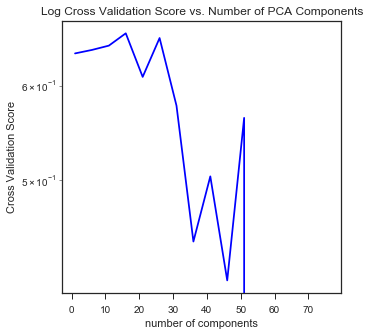

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(range(1, 80, 5), x_val_scores, color='blue')

ax.set_title('Log Cross Validation Score vs. Number of PCA Components')
ax.set_xlabel('number of components')
ax.set_ylabel('Cross Validation Score')
ax.set_yscale('log')

plt.show()

In [20]:
best_n = range(1, 80, 5)[np.argmax(x_val_scores)]

pca = PCA(n_components=best_n)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

regression_model.fit(X_train_pca, y_non_test)
test_R_sq = regression_model.score(X_test_pca, y_test)

print('best regularization param is:', best_n)
print('the test R^2 for PC regression with n = {} is: {}'.format(best_n, test_R_sq))

best regularization param is: 16
the test R^2 for PC regression with n = 16 is: 0.42404700452151367
